# Monte Carlo Dispersion Analysis using MRS (Multivariable Rejection Sampling)

## Clone repository if using Google Colab

In [ ]:
!git clone https://github.com/Projeto-Jupiter/RocketPaper.git
import os
os.chdir('RocketPaper/Multivariate Rejection Sampling')

## Initialization Cells

In [1]:
from datetime import datetime
import glob
import numpy as np
import IPython
import scipy.stats as st

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'
plt.style.use('science')

## Defining Analysis Parameters

In [3]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (8.257, 0.001),
    
    # Propulsion Details
    "impulse": (1415.15, 35.3),
    "burnOut": (5.274, 1),
    "nozzleRadius": (21.642/1000, 0.5/1000),
    "throatRadius": (8/1000, 0.5/1000),
    "grainSeparation": (6/1000, 1/1000),
    "grainDensity": (1707, 50),
    "grainOuterRadius": (21.4/1000, 0.375/1000),
    "grainInitialInnerRadius": (9.65/1000, 0.375/1000),
    "grainInitialHeight": (120/1000, 1/1000),

    # Aerodynamic Details
    "inertiaI": (3.675, 0.03675),
    "inertiaZ": (0.007, 0.00007),
    "radius": (40.45/1000,0.001),
    "distanceRocketNozzle": (-1.024,0.001),
    "distanceRocketPropellant": (-0.571,0.001),
    "powerOffDrag": (0.9081/1.05, 0.033),
    "powerOnDrag": (0.9081/1.05, 0.033),
    "noseLength": (0.274, 0.001),
    "noseDistanceToCM": (1.134, 0.001),
    "finSpan": (0.077, 0.0005),
    "finRootChord": (0.058, 0.0005),
    "finTipChord": (0.018, 0.0005),
    "finDistanceToCM": (-0.906, 0.001),

    # Launch and Environment Details
    "inclination": (84.7, 1),
    "heading": (53, 2),
    "railLength": (5.7 , 0.0005),
    # "ensembleMember": list(range(10)),
    
    # Parachute Details
    "CdSDrogue": (0.349*1.3, 0.07),
    "lag_rec": (1 , 0.5),
    
    # Electronic Systems Details
    "lag_se": (0.73, 0.16)
}

## Importing Dispersion Analysis Saved Data

In [4]:
def import_analysis(filename, display_info=False):
    dispersion_input_file = open(filename + '.valetudo_disp_in.txt')
    dispersion_output_file = open(filename + '.valetudo_disp_out.txt')

    # Initialize variable to store all loaded data
    dispersion_inputs = {
        "rocketMass": [],
        # Propulsion Details
        "impulse": [],
        "burnOut": [],
        "nozzleRadius": [],
        "throatRadius": [],
        "grainSeparation": [],
        "grainDensity": [],
        "grainOuterRadius": [],
        "grainInitialInnerRadius": [],
        "grainInitialHeight": [],
        # Aerodynamic Details
        "inertiaI": [],
        "inertiaZ": [],
        "radius": [],
        "distanceRocketNozzle": [],
        "distanceRocketPropellant": [],
        #"powerOffDrag": [],
        #"powerOnDrag": [],
        "powerOffDrag": [],
        "powerOnDrag": [],
        "noseLength": [],
        "noseDistanceToCM": [],
        "finSpan": [],
        "finRootChord": [],
        "finTipChord": [],
        "finDistanceToCM": [],
        # Launch and Environment Details
        "inclination": [],
        "heading": [],
        "railLength": [],
        # "ensembleMember": [],
        # Parachute Details
        "CdSDrogue": [],
        "lag_rec": [],
        # Electronic Systems Details
        "lag_se": [],
    }

    dispersion_outputs = {
        "outOfRailTime": [],
        "outOfRailVelocity": [],
        "apogeeTime": [],
        "apogeeAltitude": [],
        "apogeeX": [],
        "apogeeY": [],
        "impactTime": [],
        "impactX": [],
        "impactY": [],
        "impactVelocity": [],
        "initialStaticMargin": [],
        "outOfRailStaticMargin": [],
        "finalStaticMargin": [],
        "numberOfEvents": [],
        "maxVelocity": [],
        "drogueTriggerTime": [],
        "drogueInflatedTime": [],
        "drogueInflatedVelocity": [],
        "executionTime": []
    }

    # Read each line of the file and convert to dict
    for line in dispersion_input_file:
        if line[0] == '{':
            flight_result = eval(line)
            for parameter_key, parameter_value in flight_result.items():
                if parameter_key == 'ensembleMember' or parameter_key == 'ensemble_member': continue
                dispersion_inputs[parameter_key].append(parameter_value)

    for line in dispersion_output_file:
        if line[0] == '{':
            flight_result = eval(line)
            for parameter_key, parameter_value in flight_result.items():
                dispersion_outputs[parameter_key].append(parameter_value)

    # Close data files
    dispersion_input_file.close()
    dispersion_output_file.close()

    # Print number of flights simulated
    N_input = len(dispersion_inputs["rocketMass"])
    N = len(dispersion_outputs["outOfRailTime"])

    if display_info:
        print(f'File {filename}')
        print('Number of simulations in input file: ', N_input)
        print('Number of simulations in ouput file: ', N)
        # Print summary statistics
        print('Input statistics')
        for key, values in dispersion_inputs.items():
            print(f"{key:>25}: μ={np.mean(values):10.4f} | σ={np.std(values):10.4f}")

        print('Output statistics')
        for key, values in dispersion_outputs.items():
            print(f"{key:>25}: μ={np.mean(values):10.4f} | σ={np.std(values):10.4f}")

        # Print compatibility with analysis_parameters
        print('Input Deviation')
        for key, values in dispersion_inputs.items():
            # 95% confidence interval
            mean_min, mean_max = st.t.interval(0.95, len(values)-1, loc=np.mean(values), scale=st.sem(values))
            if mean_min <= analysis_parameters[key][0] <= mean_max:
                print(f"Value in:  {key:>25}: μ_error={100-100*np.mean(values)/analysis_parameters[key][0]:10.4f}% | σ={100-100*np.std(values)/analysis_parameters[key][1]:10.4f}%")
            else:
                # print('-----------------------------------------------------------------------------------')
                print(f"Value out: {key:>25}: {mean_min:10.7f} <=! {analysis_parameters[key][0]:10.7f} <=! {mean_max:10.7f}")
                # print('-----------------------------------------------------------------------------------')
                # print(f"Value out: {key:>25}: μ_error={100-100*np.mean(values)/analysis_parameters[key][0]:10.4f}% | σ={100-100*np.std(values)/analysis_parameters[key][1]:10.4f}%")
                pass
    
    return dispersion_inputs, dispersion_outputs

def import_multiple_analyses(filename_list, display_info=False):
    inputs = []
    outputs = []
    for filename in filename_list:
        analysis_inputs, analysis_outputs = import_analysis(filename, display_info)
        inputs += [analysis_inputs]
        outputs += [analysis_outputs]
    
    combined_analyses_inputs = inputs[0]
    combined_analyses_outputs = outputs[1]
    
    for key in combined_analyses_inputs.keys():
        for current_input in inputs[1:]:
            combined_analyses_inputs[key] += current_input[key]
    for key in combined_analyses_outputs.keys():
        for current_output in outputs[1:]:
            combined_analyses_outputs[key] += current_output[key]
            
    if display_info or True:
        N_input = len(combined_analyses_inputs["rocketMass"])
        N = len(combined_analyses_outputs["outOfRailTime"])
        print('Number of simulations in input file: ', N_input)
        print('Number of simulations in ouput file: ', N)
    
    return combined_analyses_inputs, combined_analyses_outputs

In [8]:
# Load data files
# filename1 = 'valetudo_reanalysis'
# filename2 = 'valetudo_reanalysis_unmodified_test'
# filename3 = 'valetudo_reanalysis_mrs_comparison_test_03_13_2020'
# filename4 = 'valetudo_reanalysis_10k'
# filename5 = 'valetudo_reanalysis_20k'
# filename6 = 'valetudo_reanalysis_mrs_test_5k'

# block1 = 'valetudo_reanalysis_ensemble_member_4_5k_block_1'
# block2 = 'valetudo_reanalysis_ensemble_member_4_5k_block_2'
# block3 = 'valetudo_reanalysis_ensemble_member_4_5k_block_3'
# block4 = 'valetudo_reanalysis_ensemble_member_4_5k_block_4'

# modified_block = 'valetudo_reanalysis_ensemble_member_4_mod_5k'
# modified_block_2 = 'valetudo_reanalysis_ensemble_member_4_mod_5k_block_2'

all_members_original_20k = r"all_members_original\all_members_20k_v2"
all_members_mrs_test_4k = r"all_members_mrs_test\all_members_mrs_test_852_4k_v2"

# Load Monte Carlos
all_members_original_20k_inputs, all_members_original_20k_outputs = import_analysis(all_members_original_20k, display_info=True)
all_members_mrs_test_4k_inputs, all_members_mrs_test_4k_outputs = import_analysis(all_members_mrs_test_4k, display_info=True)

# all_blocks_inputs, all_blocks_outputs = import_multiple_analyses([block1, block2, block3, block4], display_info=False)
# dispersion_inputs = all_blocks_inputs
# dispersion_outputs = all_blocks_outputs

File all_members_original\all_members_20k_v2
Number of simulations in input file:  20000
Number of simulations in ouput file:  20000
Input statistics
               rocketMass: μ=    8.2570 | σ=    0.0010
                  impulse: μ= 1415.8241 | σ=   35.0246
                  burnOut: μ=    5.2697 | σ=    0.9999
             nozzleRadius: μ=    0.0216 | σ=    0.0005
             throatRadius: μ=    0.0080 | σ=    0.0005
          grainSeparation: μ=    0.0060 | σ=    0.0010
             grainDensity: μ= 1706.9981 | σ=   50.0758
         grainOuterRadius: μ=    0.0214 | σ=    0.0004
  grainInitialInnerRadius: μ=    0.0097 | σ=    0.0004
       grainInitialHeight: μ=    0.1200 | σ=    0.0010
                 inertiaI: μ=    3.6751 | σ=    0.0370
                 inertiaZ: μ=    0.0070 | σ=    0.0001
                   radius: μ=    0.0405 | σ=    0.0010
     distanceRocketNozzle: μ=   -1.0240 | σ=    0.0010
 distanceRocketPropellant: μ=   -0.5710 | σ=    0.0010
             powerOffDrag

## Defining MRS Alogrithm

In [9]:
import scipy
import scipy.stats
from scipy.stats import multivariate_normal, norm, uniform, normaltest, gaussian_kde
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [10]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def test_if_gaussian(filtered_samples):
    #Test if filtered samples obey new_pdfs
    all_gaussian = True
    number_of_samples, number_of_variables = filtered_samples.shape
    
    for j in range(number_of_variables):
        # Test results
        k2, p = normaltest(filtered_samples[:, j])
        
        # null hypothesis: x comes from a normal distribution
        alpha = 1e-3
        if p < alpha: 
            # print("The null hypothesis can be rejected")
            all_gaussian = False
            
    return all_gaussian

def test_if_gaussian_single(filtered_samples):
    #Test if filtered samples obey new_pdfs
    gaussian = True
    # Test results
    k2, p = normaltest(filtered_samples)

    # null hypothesis: x comes from a normal distribution
    alpha = 1e-3
    if p < alpha: 
        # print("The null hypothesis can be rejected")
        gaussian = False
            
    return gaussian

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [11]:
def multivariate_rejection_sampling(old_pdfs, new_pdfs, samples, all_guassian=False):
    """ Applies Successive Rejection Sampling to fictious inputs of a Monte Carlo Analysis.
    
    Parameters
    ----------
    old_pdfs : list of continous random variables ([scipy.stats.rv_continuous])
        List of probability density functions used to generate inputs of a Monte Carlo analysis.
        Example: [norm(loc=0, scale=1), norm(loc=1, scale=1), uniform(loc=-0.5, scale=1.0)]
    new_pdfs : list of continous random variables ([scipy.stats.rv_continuous])
        List of new probability density functions for which you want the results of a Monte Carlo analysis.
        Order is important. Mantain the same order as old_pdfs.
        Example: [norm(loc=0.5, scale=0.5), norm(loc=1, scale=0.8), uniform(loc=-0.4, scale=0.8)]
    samples : np.array, int
        Array with all the inputs generated for the Monte Carlo analysis with old_pdfs.
        Can also be an int. If it is an int, the function creates a sample of inputs based on old_pdfs with the size
        being specified by the int.
    all_guassian : bool, optional
        Specifies if all the pdfs given are normal pdfs. If this is the case, the results are
        checked to make sure SRS is working. Default is False.  
    
    Returns
    -------
    filtered_indices : np.array
        Array which gives the indices of all the inputs and outputs iterations of the Monte Carlos
        analysis which sould be considered to get the results for the new_pdfs as inputs.
    filtered_samples : np.array
        Filtered inputs
    """
    
    # Initialize samples
    if isinstance(samples, int):
        # Generate old distribution
        samples = np.zeros((samples, number_of_variables))
        for j, pdf in enumerate(old_pdfs):
            samples[:, j] = pdf.rvs(number_of_samples)
    if isinstance(samples, pd.DataFrame):
        samples_dataframe = samples
        samples = samples.to_numpy()
      
    number_of_samples, number_of_variables = samples.shape
    
    # Calculate coefficients Ms
    M = []
    for j in range(number_of_variables):
        # Calculate M
        x_mesh = samples[:, j]
        M += [np.max(new_pdfs[j].pdf(x_mesh)/old_pdfs[j].pdf(x_mesh))]
        
    # Calculate filtering probability
    dont_filter_probability = np.ones((number_of_samples,))
    for j in range(number_of_variables):
        variable_values = samples[:, j]
        dont_filter_probability *= new_pdfs[j].pdf(variable_values)/(M[j]*old_pdfs[j].pdf(variable_values))
        
    # Roll the "gimmick" dice
    test = dont_filter_probability - uniform.rvs(size=number_of_samples)
    filtered_samples = samples[np.where(test > 0)]
    
    # Plot and print results
    number_of_filtered_samples = len(filtered_samples)
    print('Final data set size: ', 100*number_of_filtered_samples/number_of_samples, '% of', str(number_of_samples) + '.')
    
    if all_guassian:
        print('Works:', test_if_gaussian(filtered_samples))
        
    filtered_indices = np.where(test > 0)
    return filtered_indices, filtered_samples

## Running MRS

In [22]:
# Inputs:
#  analysis_parameters
#  dispersion_inputs
#  dispersion_outputs

input_dataframe = pd.DataFrame.from_dict(all_members_original_20k_inputs)
output_dataframe = pd.DataFrame.from_dict(all_members_original_20k_outputs)

# Form old pdfs
old_pdfs = []
for parameter_key, parameter_value in analysis_parameters.items():
    old_pdfs += [norm(loc=parameter_value[0], scale=parameter_value[1])]

new_pdfs = old_pdfs[:]
# Change inclination
new_pdfs[-6] = norm(85.2, 1)
# Change heading
new_pdfs[-5] = norm(53, 1.5)

# Perform MRS
filtered_indices = []
for i in range(1):
    filtered_indices_temp, filtered_samples = multivariate_rejection_sampling(old_pdfs, new_pdfs, input_dataframe, all_guassian=True)
    filtered_indices += list(filtered_indices_temp[0])
    
# Get filtered inputs and outputs
filtered_inputs_dataframe = input_dataframe.iloc[filtered_indices]
filtered_outputs_dataframe = output_dataframe.iloc[filtered_indices]

print('Number of MRS data points:', len(filtered_indices))

# Print summary statistics
print('Input statistics')
for key, values in filtered_inputs_dataframe.iteritems():
    print(f"{key:>25}: μ={np.mean(values):10.4f} | σ={np.std(values):10.4f}")

print('Output statistics')
for key, values in filtered_outputs_dataframe.iteritems():
    print(f"{key:>25}: μ={np.mean(values):10.4f} | σ={np.std(values):10.4f}")
    
# Print compatibility with analysis_parameters
print('Input Deviation')
for key, values in filtered_inputs_dataframe.iteritems():
    # 99% confidence interval
    mean_min, mean_max = st.t.interval(0.99, len(values)-1, loc=np.mean(values), scale=st.sem(values))
    if mean_min <= analysis_parameters[key][0] <= mean_max:
        print(f"Value in:  {key:>25}: μ_error={100-100*np.mean(values)/analysis_parameters[key][0]:10.4f}% | σ={100-100*np.std(values)/analysis_parameters[key][1]:10.4f}%")
    else:
        # print('-----------------------------------------------------------------------------------')
        print(f"Value out: {key:>25}: {mean_min:10.7f} <=! {analysis_parameters[key][0]:10.7f} <=! {mean_max:10.7f}")

Final data set size:  13.465 % of 20000.
Works: False
Number of MRS data points: 2693
Input statistics
               rocketMass: μ=    8.2570 | σ=    0.0010
                  impulse: μ= 1415.7040 | σ=   34.9863
                  burnOut: μ=    5.2807 | σ=    0.9931
             nozzleRadius: μ=    0.0216 | σ=    0.0005
             throatRadius: μ=    0.0080 | σ=    0.0005
          grainSeparation: μ=    0.0060 | σ=    0.0010
             grainDensity: μ= 1707.3053 | σ=   50.3262
         grainOuterRadius: μ=    0.0214 | σ=    0.0004
  grainInitialInnerRadius: μ=    0.0096 | σ=    0.0004
       grainInitialHeight: μ=    0.1200 | σ=    0.0010
                 inertiaI: μ=    3.6747 | σ=    0.0361
                 inertiaZ: μ=    0.0070 | σ=    0.0001
                   radius: μ=    0.0405 | σ=    0.0010
     distanceRocketNozzle: μ=   -1.0240 | σ=    0.0010
 distanceRocketPropellant: μ=   -0.5710 | σ=    0.0010
             powerOffDrag: μ=    0.8666 | σ=    0.0328
              pow

In [13]:
%timeit multivariate_rejection_sampling(old_pdfs, new_pdfs, input_dataframe, all_guassian=True)

Final data set size:  13.445 % of 20000.
Works: False
Final data set size:  12.985 % of 20000.
Works: False
Final data set size:  13.195 % of 20000.
Works: False
Final data set size:  13.315 % of 20000.
Works: False
Final data set size:  13.185 % of 20000.
Works: False
Final data set size:  13.525 % of 20000.
Works: False
Final data set size:  13.39 % of 20000.
Works: False
Final data set size:  13.14 % of 20000.
Works: False
420 ms ± 75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
20000*(13.53+13.43+13.405+13.305+13.16+13.985+13.32+13.395)/8/100

2688.2499999999995

## Export MRS results

In [23]:
# Basic analysis info
filename = 'all_members_mrs_result_852_4k_v2_block2'

# Create data files for inputs, outputs and error logging
dispersion_input_file = open(str(filename)+'.valetudo_disp_in.txt', 'w')
dispersion_output_file = open(str(filename)+'.valetudo_disp_out.txt', 'w')

input_dict_list = filtered_inputs_dataframe.to_dict(orient='records')
output_dict_list = filtered_outputs_dataframe.to_dict(orient='records')

for input_dict in input_dict_list:
    dispersion_input_file.write(str(input_dict) + '\n')

for output_dict in output_dict_list:
    dispersion_output_file.write(str(output_dict) + '\n')

dispersion_input_file.close()
dispersion_output_file.close()

## Results

<ipython-input-37-2c6fa874c7b7>:62: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = points[:,None]


Done


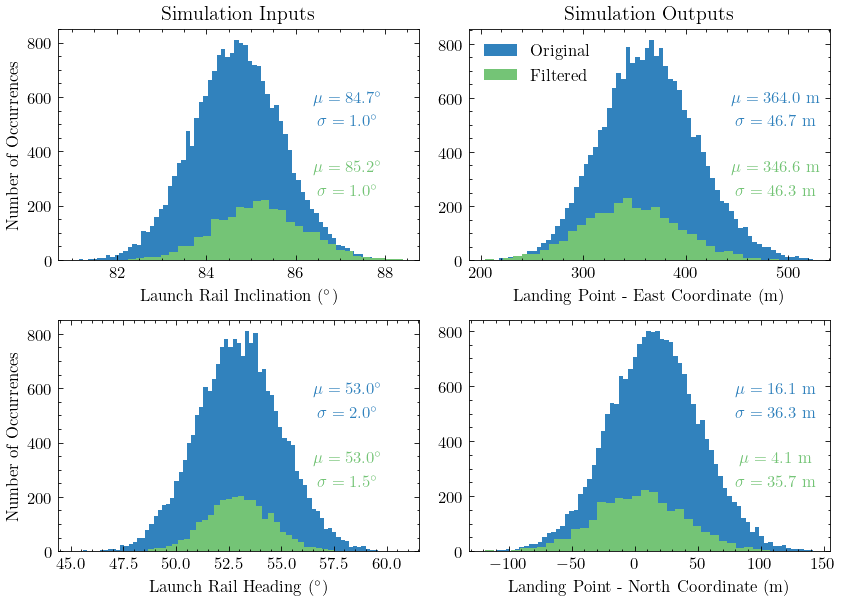

In [41]:
num_lines = 2

input_plots = {
    "rocketMass": False, # "Rocket Dry Mass (kg)",
    # Propulsion Details
    "impulse": False, # "Motor Impulse (Ns)",
    "burnOut": False,
    "nozzleRadius": False,
    "throatRadius": False,
    "grainSeparation": False,
    "grainDensity": False,
    "grainOuterRadius": False,
    "grainInitialInnerRadius": False,
    "grainInitialHeight": False,
    # Aerodynamic Details
    "inertiaI": False,
    "inertiaZ": False,
    "radius": False,
    "distanceRocketNozzle": False,
    "distanceRocketPropellant": False,
    #"powerOffDrag": False,
    #"powerOnDrag": False,
    "powerOffDrag": False,
    "powerOnDrag": False,
    "noseLength": False,
    "noseDistanceToCM": False,
    "finSpan": False,
    "finRootChord": False,
    "finTipChord": False,
    "finDistanceToCM": False,
    # Launch and Environment Details
    "windDirection": False,
    "windSpeed": False,
    "inclination": "Launch Rail Inclination ($^{\circ}$)",
    "heading": "Launch Rail Heading ($^{\circ}$)",
    "railLength": False,
    # "ensemble_member": False,
    # Parachute Details
    "CdSDrogue": False,
    "lag_rec": False,
    # Electronic Systems Details
    "lag_se": False
}

output_plots = {
    "outOfRailTime": False,
    "outOfRailVelocity": False,
    "apogeeTime": False,
    "apogeeAltitude": False, # "Apogee Altitude - AGL (m)",
    "apogeeX": False,
    "apogeeY": False,
    "impactTime": False,
    "impactX": "Landing Point - East Coordinate (m)",
    "impactY": "Landing Point - North Coordinate (m)",
    "impactVelocity": False,
    "initialStaticMargin": False,
    "outOfRailStaticMargin": False,
    "finalStaticMargin": False,
    "numberOfEvents": False,
    "maxVelocity": False, # "Maximum Velocity",
    "drogueTriggerTime": False,
    "drogueInflatedTime": False,
    "drogueInflatedVelocity": False
}

number_of_input_variables = len(input_dataframe.columns)
number_of_output_variables = len(output_dataframe.columns)

fig = plt.figure(figsize=(7, 2.5*num_lines), dpi=120, constrained_layout=True)
gs = fig.add_gridspec(num_lines, 2)

colors =  plt.cm.tab20c( (4./3*np.arange(20*3/4)).astype(int) )

# Plot inputs
i = 0
for variable_name, values in input_dataframe.iteritems():
    if input_plots[variable_name]:
        filtered_values = values[filtered_indices]
        ax = fig.add_subplot(gs[i, 0])
        ax.hist(values, 'fd', label='Original', color=colors[0])
        ax.hist(filtered_values, 'fd', label='Filtered', color=colors[7])
        ax.text(0.8, 0.7,
            f'$\\mu={np.mean(values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[0]
        )
        ax.text(0.8, 0.6,
            f'$\\sigma={np.std(values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[0]
        )
        ax.text(0.8, 0.4,
            f'$\\mu={np.mean(filtered_values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[7]
        )
        ax.text(0.8, 0.3,
            f'$\\sigma={np.std(filtered_values):0.1f}^{{\\circ}}$',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[7]
        )
        # x_mesh = np.linspace(np.min(values), np.max(values), 200)
        # ax.plot(x_mesh, gaussian_kde(values)(x_mesh), fontweight='bold', color=colors[0], label='Original')
        # ax.plot(x_mesh, gaussian_kde(filtered_values)(x_mesh), color=colors[7], label='SRS result')
        ax.set_xlabel(input_plots[variable_name])
        ax.set_ylabel('Number of Occurrences')
        # ax.legend(loc=1)
        if i == 0:
            ax.set_title('Simulation Inputs')
        i += 1

# Plot outputs
i = 0
for variable_name, values in output_dataframe.iteritems():
    if variable_name == 'executionTime': continue
    if output_plots[variable_name]:
        filtered_values = values[filtered_indices]
        ax = fig.add_subplot(gs[i, 1])
        ax.hist(values[~is_outlier(values)], 'fd', label='Original', color=colors[0])
        ax.hist(filtered_values[~is_outlier(filtered_values)], 'fd', label='Filtered', color=colors[7])
        ax.text(0.85, 0.7,
            f'$\\mu={np.mean(values[~is_outlier(values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[0]
        )
        ax.text(0.85, 0.6,
            f'$\\sigma={np.std(values[~is_outlier(values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[0]
        )
        ax.text(0.85, 0.4,
            f'$\\mu={np.mean(filtered_values[~is_outlier(filtered_values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[7]
        )
        ax.text(0.85, 0.3,
            f'$\\sigma={np.std(filtered_values[~is_outlier(filtered_values)]):0.1f}$ m',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, weight='bold', color=colors[7]
        )
        # x_mesh = np.linspace(np.min(values), np.max(values), 200)
        # ax.plot(x_mesh, gaussian_kde(values)(x_mesh), color='b', label='Original')
        # ax.plot(x_mesh, gaussian_kde(filtered_values)(x_mesh), color='r', label='SRS result')
        ax.set_xlabel(output_plots[variable_name])
        if i == 0:
            ax.set_title('Simulation Outputs')
            ax.legend(loc=2)
        i += 1

print('Done')
plt.savefig('MRS_results_v1.pdf')  
plt.show()

In [30]:
for variable_name, values in output_dataframe.iteritems():
    if output_plots[variable_name]:
        filtered_values = values[filtered_indices]
        print(mean_confidence_interval(values, confidence=0.999))
        print(mean_confidence_interval(filtered_values, confidence=0.999))

(387.41544148404876, 1.1424650079735257)
(378.203442299855, 2.4584313291391124)
(-0.21956565235608472, 0.9038192761562976)
(-7.641151927944785, 1.9098390441153692)


In [ ]:
for variable_name, values in output_dataframe.iteritems():
    filtered_values = np.array(values[filtered_indices])
    print(variable_name, ':', test_if_gaussian_single(filtered_values))
    print('Mean:', np.mean(filtered_values), '| Std:', np.std(filtered_values))

outOfRailTime : True
Mean: 1.0838162951862902 | Std: 0.18801649615642996
outOfRailVelocity : False
Mean: 23.10390847713462 | Std: 3.1924597881632573
apogeeTime : False
Mean: 14.314225839573236 | Std: 0.35357424453301844
apogeeAltitude : True
Mean: 847.2612864988338 | Std: 43.58654649210127
apogeeX : True
Mean: 97.22722541213119 | Std: 24.61485231640024
apogeeY : True
Mean: 102.25976949710646 | Std: 19.67210459398819
impactTime : False
Mean: 63.03346629333131 | Std: 4.260602780395271
impactX : True
Mean: 374.7961891291166 | Std: 48.73433568883495
impactY : False
Mean: -9.861698017924292 | Std: 37.93713882746361
impactVelocity : False
Mean: -18.266708736470665 | Std: 2.199061072656426
initialStaticMargin : False
Mean: 1.9921068180402426 | Std: 0.3262296346349559
outOfRailStaticMargin : False
Mean: 2.1728399973370247 | Std: 0.3296009282772833
finalStaticMargin : False
Mean: 3.0201787420307338 | Std: 0.34571378291832056
numberOfEvents : True
Mean: 1.0 | Std: 0.0
maxVelocity : True
Mean: 12

# Comparing Analyses

In [28]:
def are_distributions_equal(dataset1, dataset2, min_p_value=0.01):
    _, p_value = st.ks_2samp(dataset1, dataset2)
    return True if p_value >= min_p_value else p_value

In [29]:
# Load Monte Carlo
# analysis_inputs_1, analysis_outputs_1 = import_analysis(block1)
# analysis_inputs_2, analysis_outputs_2 = import_analysis(block2)
# analysis_inputs_2, analysis_outputs_2 = import_analysis(block4)
# analysis_inputs_2, analysis_outputs_2 = all_blocks_inputs, all_blocks_outputs

# Load MRS
analysis_inputs_1 = all_members_mrs_test_4k_inputs
analysis_outputs_1 = all_members_mrs_test_4k_outputs
analysis_inputs_2 = {variable_name: values[filtered_indices] for variable_name, values in input_dataframe.iteritems()}
analysis_outputs_2 = {variable_name: values[filtered_indices] for variable_name, values in output_dataframe.iteritems()}

print('Are distributions equal?')
print('Inputs:')
for key in analysis_inputs_1:
    dataset1 = analysis_inputs_1[key]
    dataset2 = analysis_inputs_2[key]
    if isinstance(are_distributions_equal(dataset1, dataset2), bool):
        print(f"{key:>25}: {are_distributions_equal(dataset1, dataset2)}")
    else:
        print(f"{key:>25}: {are_distributions_equal(dataset1, dataset2)} | μ1={np.mean(dataset1):10.4f} | μ2={np.mean(dataset2):10.4f}")

print('Outputs:')
for key in analysis_outputs_1:
    dataset1 = analysis_outputs_1[key]
    dataset2 = analysis_outputs_2[key]
    if isinstance(are_distributions_equal(dataset1, dataset2), bool):
        print(f"{key:>25}: {are_distributions_equal(dataset1, dataset2)}")
    else:
        print(f"{key:>25}: {are_distributions_equal(dataset1, dataset2)} | μ1={np.mean(dataset1):10.4f} | μ2={np.mean(dataset2):10.4f}")

Are distributions equal?
Inputs:
               rocketMass: True
                  impulse: True
                  burnOut: True
             nozzleRadius: True
             throatRadius: True
          grainSeparation: True
             grainDensity: True
         grainOuterRadius: True
  grainInitialInnerRadius: True
       grainInitialHeight: True
                 inertiaI: True
                 inertiaZ: True
                   radius: True
     distanceRocketNozzle: True
 distanceRocketPropellant: True
             powerOffDrag: True
              powerOnDrag: True
               noseLength: True
         noseDistanceToCM: True
                  finSpan: True
             finRootChord: True
              finTipChord: True
          finDistanceToCM: True
              inclination: True
                  heading: True
               railLength: True
                CdSDrogue: True
                  lag_rec: True
                   lag_se: True
Outputs:
            outOfRailTime: Tru

# Bootstrap

In [60]:
def bootstrap_ci(
    data, 
    statfunction=np.average, 
    alpha = 0.05, 
    n_samples = 100):

    """inspired by https://github.com/cgevans/scikits-bootstrap"""
    import warnings

    def bootstrap_ids(data, n_samples=100):
        for _ in range(n_samples):
            yield np.random.randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha/2, 1 - alpha/2])
    nvals = np.round((n_samples - 1) * alphas).astype(int)
    if np.any(nvals < 10) or np.any(nvals >= n_samples-10):
        warnings.warn("Some values used extremal samples; results are probably unstable. "
                      "Try to increase n_samples")

    data = np.array(data)
    if np.prod(data.shape) != max(data.shape):
        raise ValueError("Data must be 1D")
    data = data.ravel()
    
    boot_indexes = bootstrap_ids(data, n_samples)
    stat = np.asarray([statfunction(data[_ids]) for _ids in boot_indexes])
    stat.sort(axis=0)

    lower, upper = stat[nvals]
    
    return (upper-lower)/2

In [61]:
dataset1 = all_members_original_20k_outputs['impactX']
dataset2 = analysis_outputs_2['impactX']

print(bootstrap_ci(dataset1, statfunction=np.mean, alpha=0.05, n_samples=1000))
print(bootstrap_ci(dataset1, statfunction=np.mean, alpha=0.05, n_samples=10000))

print(bootstrap_ci(dataset2, statfunction=np.mean, alpha=0.05, n_samples=1000))
print(bootstrap_ci(dataset2, statfunction=np.mean, alpha=0.05, n_samples=10000))

0.6011926610673015
0.6508811508543886
1.7914282498892646
1.7341375153732486


In [141]:
np.average(dataset1) + np.std(dataset1)/np.sqrt(len(dataset1))

13.329780194193496

# Find Best Ensemble Member

In [162]:
for member in range(10):
    analysis_name = f"valetudo_reanalysis_ensemble_member_{member}"
    analysis_inputs, analysis_outputs = import_analysis(analysis_name, display_info=False)
    
    impactX = np.mean(analysis_outputs['impactX'])
    impactY = np.mean(analysis_outputs['impactY'])
    delta = ((impactX - 410)**2 + (impactY - (-70))**2)**0.5
    
    print(f"Ensemble member {member}: μ_x = {impactX:6.2f} m | μ_y = {impactY:6.2f} m | Δ = {delta:6.2f} m")


Ensemble member 0: μ_x = 353.95 m | μ_y =  22.16 m | Δ = 107.87 m
Ensemble member 1: μ_x = 350.86 m | μ_y =  19.05 m | Δ = 106.90 m
Ensemble member 2: μ_x = 386.93 m | μ_y =   8.87 m | Δ =  82.17 m
Ensemble member 3: μ_x = 370.27 m | μ_y =  14.42 m | Δ =  93.30 m
Ensemble member 4: μ_x = 403.54 m | μ_y = -12.80 m | Δ =  57.57 m
Ensemble member 5: μ_x = 367.63 m | μ_y =  12.61 m | Δ =  92.84 m
Ensemble member 6: μ_x = 337.05 m | μ_y =  26.53 m | Δ = 121.00 m
Ensemble member 7: μ_x = 341.72 m | μ_y =   5.86 m | Δ = 102.06 m
Ensemble member 8: μ_x = 356.30 m | μ_y =  39.10 m | Δ = 121.60 m
Ensemble member 9: μ_x = 357.92 m | μ_y =  37.69 m | Δ = 119.62 m
